<a href="https://colab.research.google.com/github/niss10/IS-698-FL-Project/blob/main/FedCollab_CML_FL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementing Centralize Machine Learning and Federated Learning on MLP

# Prerequisite - Environment Setup
1. Run the below cell
2. Then, RESTART the Colab runtime. (after succefull completion)
3. After Restarting don't run this cell

In [ ]:

# Force‑reinstall NumPy and scikit‑learn
!pip install --upgrade --force-reinstall numpy==1.24.3 scikit-learn

# Install the CPU‑only PyTorch build
!pip uninstall -y torch torchvision
!pip install --index-url https://download.pytorch.org/whl/cpu torch torchvision

# Install/latest versions of Flower and PyTorch
!pip install --upgrade flwr pandas
!pip install -U "flwr[simulation]"

# Then, RESTART the Colab runtime.

# After Restarting don't run this cell

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 79.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.7/37.7 MB 16.0 MB/s eta 0:00:00
  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 3.6.0
    Uninstalling threadpoolctl-3.6.0:
      Successfully uninstalled threadpoolctl-3.6.0
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: joblib
    Found existing installation: joblib 1.5.0
    Uninstalling joblib-1.5.0:
      Successfully uninstalled joblib-1.5.0
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfu

Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Looking in indexes: https://download.pytorch.org/whl/cpu
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.0/176.0 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 96.4 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.1
    Uninstalling sympy-1.13.1:
      Successfully uninstalled sympy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.19 requires torch<2.7,>=1.10, but you have torch 2.7.0+cpu which is incompatible.
torchaudio 2.6.0+cu12

## Import required libraries

In [ ]:
# Import required libraries
import flwr as fl
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from flwr.server.strategy import FedAvg
from flwr.client import NumPyClient
import matplotlib.pyplot as plt
import os
from pathlib import Path
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Adding Master file
Setting source of truth file that we will use for federated learning simulation

upload the downloaded preprocessed_dataset.csv from Dataset/Pre-Processed/ folder

In [ ]:

# Adding Master dataset file
print("Please upload preprocessed_dataset.csv")
uploaded = files.upload()  # upload the downloaded preprocessed_dataset.csv
if(uploaded):
  print("File uploaded successfully")
else:
  print("File upload failed, Please upload again")
  uploaded = files.upload()

Please upload preprocessed_dataset.csv


Saving preprocessed_dataset.csv to preprocessed_dataset.csv
File uploaded successfully


# Data Partitioning for Client simulations

In [ ]:
# Data Partitioning Utility

# Load the master preprocessed dataset.
def load_master(csv_path):
    return pd.read_csv(csv_path)

# Randomly select N different user from all
def sample_user_ids(df, num_clients, seed=42):
    user_ids = df["UserID"].unique()
    rng = np.random.default_rng(seed)
    if num_clients >= len(user_ids):
        return list(user_ids)
    return list(rng.choice(user_ids, size=num_clients, replace=False))

# Save each selected user's rating to out_dir/user_{uid}.csv
def partition_by_user(df, out_dir, user_ids=None):
    out_path = Path(out_dir)
    out_path.mkdir(parents=True, exist_ok=True)

    if user_ids is None:
        user_ids = df["UserID"].unique()

    csv_paths = []
    for uid in user_ids:
        df_user = df[df["UserID"] == uid]
        path = out_path / f"user_{uid}.csv"
        df_user.to_csv(path, index=False)
        csv_paths.append(str(path))
    return csv_paths

## Sanity check data of partioning

In [ ]:

# Load the master dataset that we have uploaded earlier
MASTER_CSV = "preprocessed_dataset.csv"
df_master  = load_master(MASTER_CSV)
print("Rows:", len(df_master), " | Users:", df_master['UserID'].nunique(), " | Movie:", df_master['MovieID'].nunique())

# Cheking for 5 clients
paths_5   = partition_by_user(df_master, "clients_5",   sample_user_ids(df_master, 5))


print(f"5-client num files:   {len(paths_5)}")
print(f"5-client files:   {paths_5}")


<ipython-input-3-2292d8e7e956>:5: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(csv_path)


Rows: 1000209  | Users: 6040  | Movie: 3706
5-client num files:   5
5-client files:   ['clients_5/user_4673.csv', 'clients_5/user_2651.csv', 'clients_5/user_3953.csv', 'clients_5/user_539.csv', 'clients_5/user_2616.csv']


# Model & Local-Training Utilities
In this section we are difining model and how model will train data we have used REcommenderMLP using Pytorch for training.

## Loading Local data and Train/Test Split

In [ ]:
# Return train & test DataLoaders for one client CSV.
def load_client_data(csv_path, batch_size=32, test_size=0.2, seed=42):
    df = pd.read_csv(csv_path)
    users  = torch.tensor(df["UserID"].values,   dtype=torch.long)
    movies = torch.tensor(df["MovieID"].values,  dtype=torch.long)
    ratings= torch.tensor(df["Rating"].values,   dtype=torch.float32)

    idx = np.arange(len(df))
    rng = np.random.default_rng(seed)
    rng.shuffle(idx)
    split = int((1 - test_size) * len(idx))
    train_idx, test_idx = idx[:split], idx[split:]

    train_ds = TensorDataset(users[train_idx], movies[train_idx], ratings[train_idx])
    test_ds  = TensorDataset(users[test_idx],  movies[test_idx],  ratings[test_idx])

    return (DataLoader(train_ds, batch_size=batch_size, shuffle=True),
            DataLoader(test_ds,  batch_size=batch_size, shuffle=False))

## Model

In [ ]:
# Defining RecommenderMLP Model using Pytorch

# User-embedding + Movie-embedding -> 2-layer MLP[64 -> ReLu] -> rating (1-5).
class RecommenderMLP(nn.Module):
    def __init__(self, num_users, num_movies,
                 embed_dim=32, hidden=64):
        super().__init__()
        self.user_embed  = nn.Embedding(num_users  + 1, embed_dim)
        self.movie_embed = nn.Embedding(num_movies + 1, embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim * 2, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1)
        )

    def forward(self, user_ids, movie_ids):
        u = self.user_embed(user_ids)
        m = self.movie_embed(movie_ids)
        x = torch.cat([u, m], dim=1)
        return self.mlp(x).squeeze(1)


## Training and Evaluation

In [ ]:
# Utility for loading data into tensor for client and training and evalation

# this function will train Model for one epoch
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total, count = 0.0, 0
    for u, m, r in loader:
        u, m, r = u.to(device), m.to(device), r.to(device)
        optimizer.zero_grad()
        loss = criterion(model(u, m), r)
        loss.backward()
        optimizer.step()
        total += loss.item() * len(r)
        count += len(r)
    return total / count

# Evaluate train model on test dataset and return loss
def evaluate(model, loader, criterion, device):
    model.eval()
    total, count = 0.0, 0
    with torch.no_grad():
        for u, m, r in loader:
            u, m, r = u.to(device), m.to(device), r.to(device)
            loss = criterion(model(u, m), r)
            total += loss.item() * len(r)
            count += len(r)
    return total / count

## Quick Sanity Check of Model

In [ ]:
# running model for 1 user from 5 client we have created to check how it works
sample_csv = "clients_5/" + sorted(os.listdir("clients_5"))[0]

# Get dataset dimensions for embeddings
num_users  = df_master["UserID"].max()
num_movies = df_master["MovieID"].max()

# Build loaders and model
train_loader, test_loader = load_client_data(sample_csv, batch_size=16)
device = torch.device("cpu")
model  = RecommenderMLP(num_users, num_movies).to(device)

opt  = torch.optim.Adam(model.parameters(), lr=1e-3)
crit = torch.nn.MSELoss()

Train_loss = train_one_epoch(model, train_loader, opt, crit, device)
Test_loss  = evaluate(model, test_loader, crit, device)

print("Train loss:", Train_loss)
print("Test  loss:", Test_loss)


Train loss: 11.51661376953125
Test  loss: 11.527342796325684


# Centralize Machine Learning on RecommenderMLP

## Setting up Data for Training

In [ ]:

def train_centralized(
    df: pd.DataFrame,
    user_ids: list,
    num_epochs: int = 30,
    test_size: float = 0.2,
):
    """
    Train RecommenderMLP centrally on data for specified user_ids.
    Returns MSE and RMSE on test set.
    """
    # Filter data for selected users
    df_users = df[df["UserID"].isin(user_ids)]

    # Split into train and test sets
    rng = np.random.default_rng(seed=42)
    idx = np.arange(len(df_users))
    rng.shuffle(idx)
    split = int((1 - test_size) * len(idx))
    train_idx, test_idx = idx[:split], idx[split:]

    # Prepare tensors
    train_users = torch.tensor(df_users["UserID"].values[train_idx], dtype=torch.long)
    train_movies = torch.tensor(df_users["MovieID"].values[train_idx], dtype=torch.long)
    train_ratings = torch.tensor(df_users["Rating"].values[train_idx], dtype=torch.float32)
    test_users = torch.tensor(df_users["UserID"].values[test_idx], dtype=torch.long)
    test_movies = torch.tensor(df_users["MovieID"].values[test_idx], dtype=torch.long)
    test_ratings = torch.tensor(df_users["Rating"].values[test_idx], dtype=torch.float32)

    # Create DataLoaders
    train_ds = TensorDataset(train_users, train_movies, train_ratings)
    test_ds = TensorDataset(test_users, test_movies, test_ratings)
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

    # Initialize model
    num_users = int(df["UserID"].max())
    num_movies = int(df["MovieID"].max())
    model = RecommenderMLP(num_users, num_movies).to(torch.device("cpu"))
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.MSELoss()

    # Train model
    device = torch.device("cpu")
    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
        print(f"Epoch {epoch+1:02d}: Train MSE={train_loss:.4f}")

    # Evaluate on test set
    central_mse = evaluate(model, test_loader, criterion, device)
    central_rmse = np.sqrt(central_mse)

    print(f"\nCentralized Test Results:")
    print(f"Centralized MSE: {central_mse:.4f}")
    print(f"Centralized RMSE: {central_rmse:.4f}")

    return central_mse, central_rmse

## Centralize Runner

In [ ]:
# Main execution
master_csv = "preprocessed_dataset.csv"
df_master = load_master(master_csv)

# Select 100 users for both centralized and FL
num_clients = 100
user_ids = sample_user_ids(df_master, num_clients, seed=42)

# Centralized training
print("\nRunning Centralized Training for 100 Users...")
central_mse, central_rmse = train_centralized(df_master, user_ids, num_epochs=3)


<ipython-input-3-2292d8e7e956>:5: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(csv_path)



Running Centralized Training for 100 Users...
Epoch 01: Train MSE=2.8569
Epoch 02: Train MSE=1.1300
Epoch 03: Train MSE=1.0397

Centralized Test Results:
Centralized MSE: 1.0958
Centralized RMSE: 1.0468


# Federated Learning on RecommenderMLP

## FL Client

In [ ]:
# Flower Client
class FLClient(NumPyClient):
    def __init__(self, model, train_loader, test_loader, device):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.device = device
        self.criterion = torch.nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)

    def get_parameters(self, config):
        return [p.cpu().numpy() for p in self.model.state_dict().values()]

    def set_parameters(self, params):
        keys = list(self.model.state_dict().keys())
        self.model.load_state_dict({k: torch.tensor(v) for k, v in zip(keys, params)}, strict=True)

    def fit(self, params, config):
        self.set_parameters(params)
        num_epochs = 3 # Default to 3 epochs
        for _ in range(num_epochs):
            train_one_epoch(self.model, self.train_loader, self.optimizer, self.criterion, self.device)
        return self.get_parameters(config), len(self.train_loader.dataset), {}

    def evaluate(self, params, config):
        self.set_parameters(params)
        loss = evaluate(self.model, self.test_loader, self.criterion, self.device)
        return float(loss), len(self.test_loader.dataset), {}

# Federated Runner + Server

In [ ]:
# Run a FedAvg simulation for <num_clients> clients over <num_rounds>.
# Returns Flower history for later analysis.

def run_federated(
    df_master,
    num_clients,
    num_rounds = 10,
):
    # Below code will Pick user IDs that will participate
    selected_uids = sample_user_ids(df_master,num_clients)

    # Now getting csv file paths per user/clients
    folder = f"clients_{num_clients}"
    csv_paths = partition_by_user(df_master, folder, selected_uids)

    # client function
    num_users  = int(df_master["UserID"].max())
    num_movies = int(df_master["MovieID"].max())

    def client_fn(cid: str):
        idx  = int(cid)
        csv  = csv_paths[idx]   # csv file per user that we have created earlier
        client_training_data, client_test_data = load_client_data(csv, batch_size=32) # Creating training data and test data from those per user/clent csv file
        model  = RecommenderMLP(num_users, num_movies)
        return FLClient(model, client_training_data, client_test_data, device=torch.device("cpu")).to_client()

    # FedAvg strategy Server
    strategy = FedAvg(
        fraction_fit=1.0,
        fraction_evaluate=1.0,
        min_fit_clients=num_clients,
        min_evaluate_clients=num_clients,
        min_available_clients=num_clients,
    )

    # Run simulation
    history = fl.simulation.start_simulation(
        client_fn        = client_fn,
        num_clients      = num_clients,
        strategy         = strategy,
        config           = fl.server.ServerConfig(num_rounds=num_rounds),
        client_resources = {"num_cpus": 1},
    )

    #  Report metrics
    print(f"\nFederated results for {num_clients} clients:")
    print(history.losses_distributed)
    mse_values = []
    rmse_values = []
    for r, mse in history.losses_distributed:
        print(f"Round {r:02d}:  MSE={mse:8.4f}   RMSE={np.sqrt(mse):6.4f}")
        mse_values.append(mse)
        rmse_values.append(np.sqrt(mse))

    return history, mse_values, rmse_values


# Triggering Federated Learning

In [ ]:
# Main execution
master_csv = "preprocessed_dataset.csv"
df_master = load_master(master_csv)

# setting clients and rounds
num_clients = 100
num_rounds = 10
num_epochs = 3
user_ids = sample_user_ids(df_master, num_clients, seed=42)

# Centralized training
print(f"\nRunning Centralized Training for {num_clients} Users...")
central_mse, central_rmse = train_centralized(df_master, user_ids, num_epochs=num_epochs)

# Federated training
print(f"\nRunning Federated Training for {num_clients} Clients...")
history_100, mse_values, rmse_values = run_federated(
    df_master, num_clients=num_clients, num_rounds=num_rounds)

<ipython-input-3-2292d8e7e956>:5: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(csv_path)



Running Centralized Training for 100 Users...
Epoch 01: Train MSE=2.6711
Epoch 02: Train MSE=1.1053
Epoch 03: Train MSE=1.0253

Centralized Test Results:
Centralized MSE: 1.1049
Centralized RMSE: 1.0512

Running Federated Training for 100 Clients...


	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout
2025-05-18 22:45:55,069	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resource


Federated results for 100 clients:
[(1, 10.62880342013901), (2, 8.087881416834207), (3, 6.167317390953135), (4, 4.779935105747941), (5, 3.7915880642493005), (6, 3.101494101023698), (7, 2.6265621161244352), (8, 2.303378303885821), (9, 2.0852108555502897), (10, 1.9313429933112758)]
Round 01:  MSE= 10.6288   RMSE=3.2602
Round 02:  MSE=  8.0879   RMSE=2.8439
Round 03:  MSE=  6.1673   RMSE=2.4834
Round 04:  MSE=  4.7799   RMSE=2.1863
Round 05:  MSE=  3.7916   RMSE=1.9472
Round 06:  MSE=  3.1015   RMSE=1.7611
Round 07:  MSE=  2.6266   RMSE=1.6207
Round 08:  MSE=  2.3034   RMSE=1.5177
Round 09:  MSE=  2.0852   RMSE=1.4440
Round 10:  MSE=  1.9313   RMSE=1.3897


# Visulization


Comparison of Centralized vs. Federated Learning (100 Users/Clients):
Method       MSE      RMSE    
Centralized  1.1049   1.0512  
Federated    1.9313   1.3897  


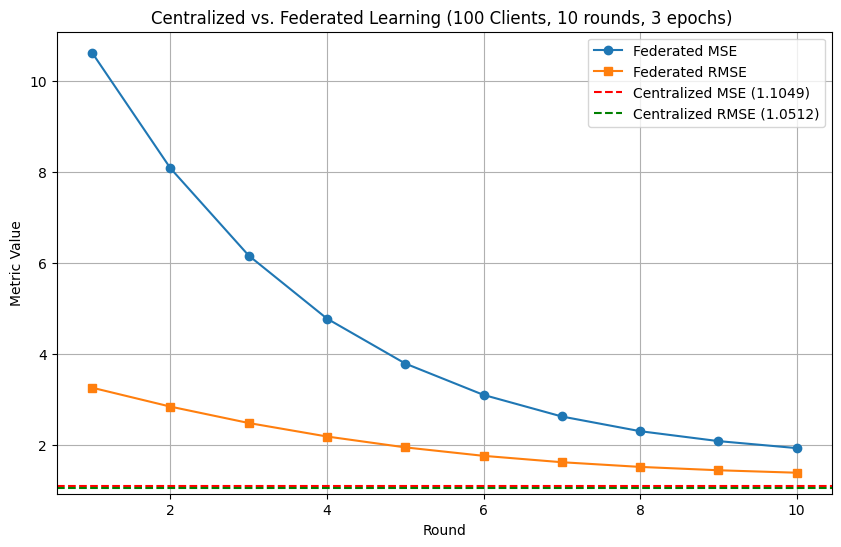

In [ ]:
# Compare Centralized vs. Federated
print(f"\nComparison of Centralized vs. Federated Learning ({num_clients} Users/Clients):")
print(f"{'Method':<12} {'MSE':<8} {'RMSE':<8}")
print(f"{'Centralized':<12} {central_mse:<8.4f} {central_rmse:<8.4f}")
print(f"{'Federated':<12} {mse_values[-1]:<8.4f} {rmse_values[-1]:<8.4f}")

# Plot MSE and RMSE
rounds = range(1, 11)
plt.figure(figsize=(10, 6))
plt.plot(rounds, mse_values, marker='o', label='Federated MSE')
plt.plot(rounds, rmse_values, marker='s', label='Federated RMSE')
plt.axhline(y=central_mse, color='r', linestyle='--', label=f'Centralized MSE ({central_mse:.4f})')
plt.axhline(y=central_rmse, color='g', linestyle='--', label=f'Centralized RMSE ({central_rmse:.4f})')
plt.xlabel('Round')
plt.ylabel('Metric Value')
plt.title(f'Centralized vs. Federated Learning ({num_clients} Clients, {num_rounds} rounds, {num_epochs} epochs) ')
plt.legend()
plt.grid(True)
plt.show()